# Recommendations with IBM

In this notebook, we will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, we will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)<br>


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import project_tests as t
import pickle
import re
import random
from typing import List, Tuple



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /Users/chrismo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/chrismo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrismo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Showing df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [7]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


# <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

A. Grouping by User count

In [10]:
user_interaction = df.groupby('email').count()['article_id']

In [11]:
user_interaction

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

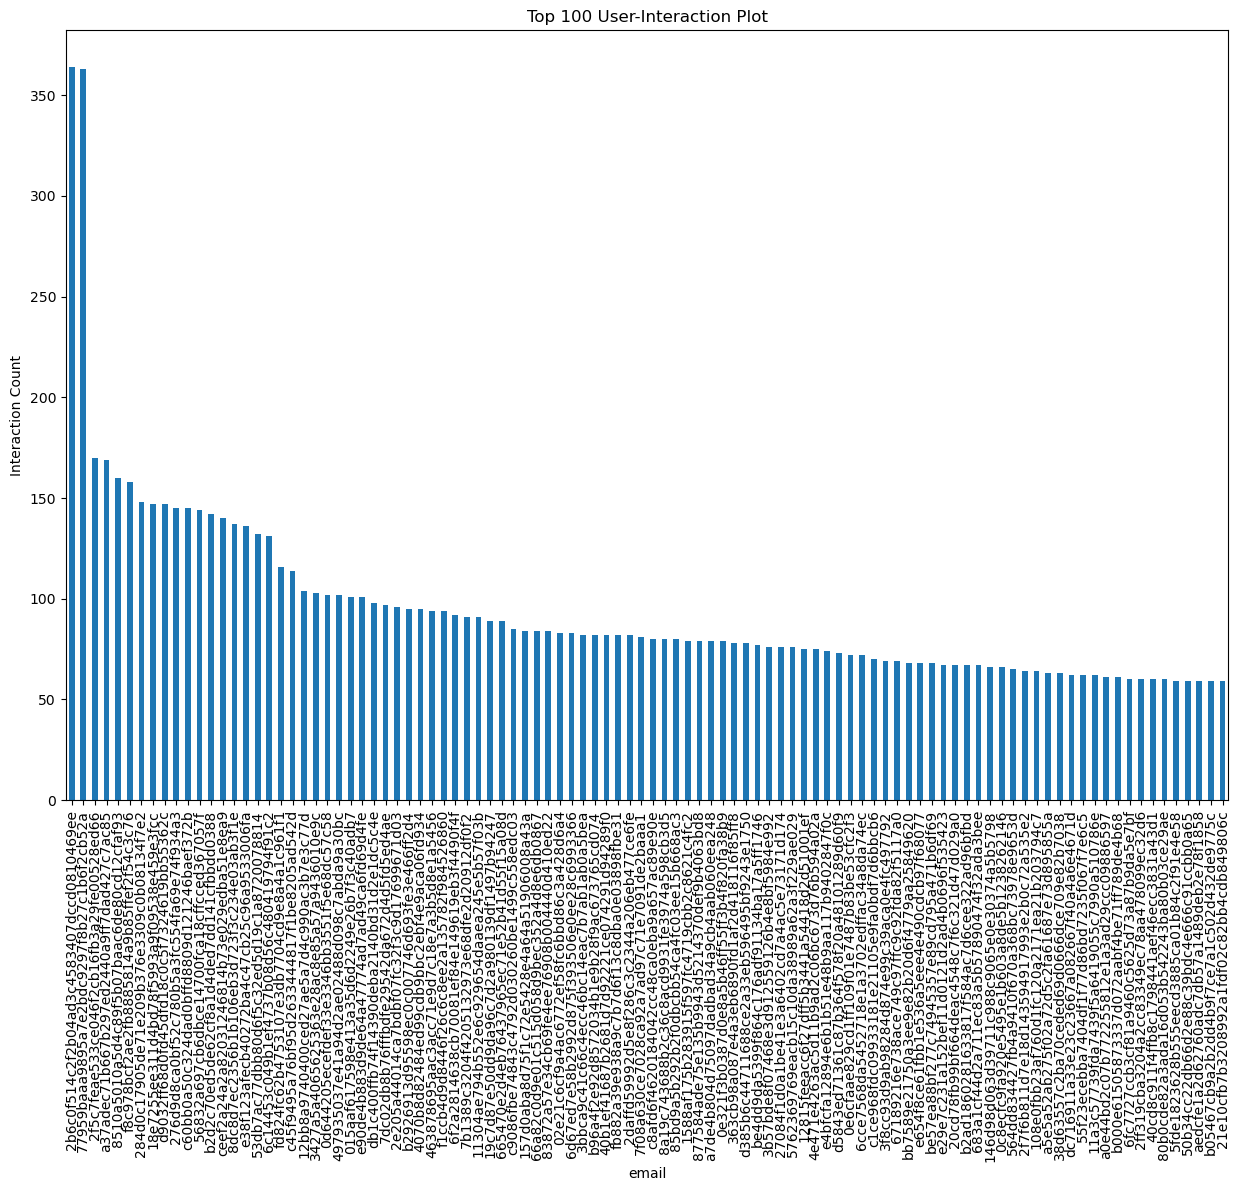

In [341]:
plt.figure(figsize=(15, 10))
user_interaction.sort_values(ascending=False).head(100).plot(kind='bar');
plt.title('Top 100 User-Interaction Plot');
plt.ylabel('Interaction Count')
plt.ylabel('Interaction Count')
plt.xticks(rotation=90);

B. Grouping by Article counts

In [14]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [15]:
df.groupby('article_id')['title'].count().sort_values(ascending=False)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1113.0      1
1119.0      1
984.0       1
1127.0      1
1266.0      1
Name: title, Length: 714, dtype: int64

In [16]:
article_counts = df.groupby('article_id').count()['email']

In [17]:
article_counts

article_id
0.0       14
2.0       58
4.0       13
8.0       85
9.0       10
          ..
1440.0    10
1441.0     8
1442.0     4
1443.0    22
1444.0     5
Name: email, Length: 714, dtype: int64

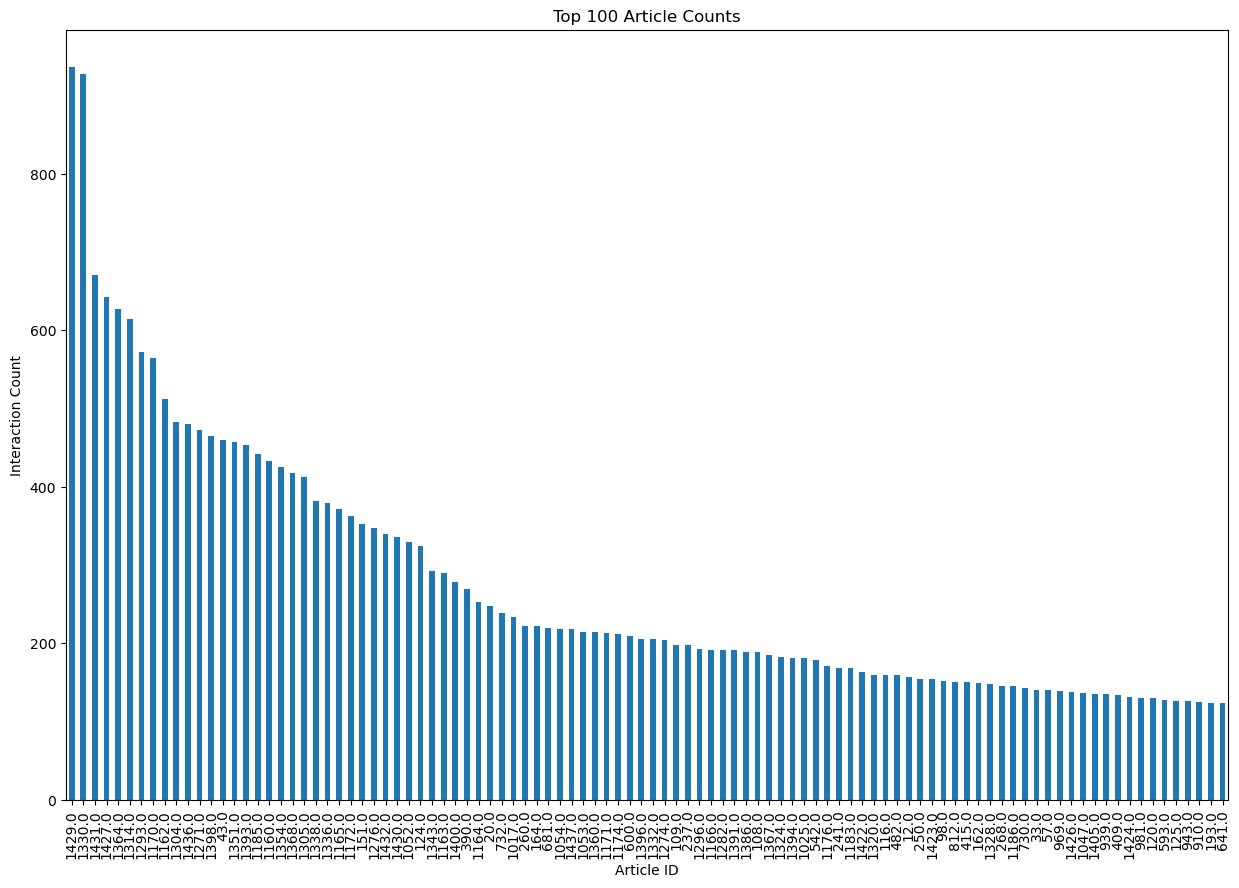

In [345]:
plt.figure(figsize=(15, 10))
article_counts.sort_values(ascending=False).head(100).plot(kind='bar');
plt.title('Top 100 Article Counts')
plt.xlabel('Article ID')
plt.ylabel('Interaction Count')
plt.xticks(rotation=90);

In [19]:
user_interaction.max()

364

In [20]:
user_interaction.median()

3.0

In [21]:
# Fill in the median and maximum number of user_article interactions below

median_val = user_interaction.median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = user_interaction.sort_values(ascending=False).max() # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [23]:
df_content['article_id'].duplicated().sum()        # finding and exploring duplicate articles

5

In [24]:
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [25]:
df_content.drop_duplicates(subset=['article_id'], inplace=True)

In [26]:
df_content['article_id'].duplicated().sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [28]:
df['article_id'].nunique()

714

In [29]:
df_content['article_id'].nunique()

1051

In [30]:
df.shape[0]

45993

In [31]:
df['email'].nunique()

5148

In [32]:
df.groupby('email').count()['article_id'].sum()

45976

In [33]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [35]:
article_counts = df.groupby('article_id').count()['email']

In [36]:
article_counts.sort_values(ascending=False).head(1)

article_id
1429.0    937
Name: email, dtype: int64

In [37]:
df.groupby('email').article_id.count().max()

364

In [38]:
most_viewed = article_counts.sort_values(ascending=False).head(1).reset_index()['email'][0]
most_viewed

937

In [39]:
int(most_viewed)

937

In [40]:
str(df.groupby('article_id')['email'].count().sort_values(ascending=False).head(1).reset_index()['article_id'][0])

'1429.0'

In [41]:
df.groupby('article_id')['title'].count().sort_values(ascending=False).head(1).reset_index()['article_id'][0]

1429.0

In [42]:
article_counts.sort_values(ascending=False).head(1).reset_index()['email'][0]

937

In [43]:
most_viewed_article_id = str(df.groupby('article_id')['email'].count().sort_values(ascending=False).head(1).reset_index()['article_id'][0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.groupby('article_id')['title'].count().sort_values(ascending=False).max()# The most viewed article in the dataset was viewed how many times?

In [44]:
df['email'].nunique()

5148

In [45]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# print head
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [46]:
## If we stored all our results in the variable names above, 
## we shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


# <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Testing our function using the tests below.

In [48]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


#### Testing our ranking system

In [50]:
(df.groupby(['article_id', 'title']).count().reset_index()['title'][:2])     #raw, trial code!

0    detect malfunctioning iot sensors with streami...
1           this week in data science (april 18, 2017)
Name: title, dtype: object

#### From the above, we see, we need to create some sort of ranking system reallt

In [52]:
ranks = df.groupby('user_id').count()['article_id']
ranks

user_id
1       47
2        6
3       82
4       45
5        5
        ..
5145     6
5146     9
5147     1
5148     1
5149     1
Name: article_id, Length: 5149, dtype: int64

In [53]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


In [54]:
df = df.merge(ranks, on='user_id') #merging with a ranking system 

In [55]:
df

,article_id_x,title,user_id,article_id_y
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5
...,...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146,9
45989,142.0,neural networks for beginners: popular types a...,5146,9
45990,233.0,bayesian nonparametric models – stats and bots,5147,1
45991,1160.0,analyze accident reports on amazon emr spark,5148,1


In [56]:
df.rename({'article_id_y':'ranking_count', 'article_id_x':'article_id'}, axis=1, inplace=True)   #renaming rank count

In [57]:
df.head()

,article_id,title,user_id,ranking_count
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5


In [58]:
df[df['ranking_count'].isna()]     #Checking for a no rank

,article_id,title,user_id,ranking_count


In [59]:
df.head()

,article_id,title,user_id,ranking_count
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5


In [60]:
def get_top_articles(n:int, df:pd.DataFrame=df) -> list:
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id', 'title']).count().sort_values(ascending=False, by='ranking_count').reset_index()['title'][:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n:int, df:pd.DataFrame=df) -> list:
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id', 'title']).count().sort_values(ascending=False, by='ranking_count').reset_index()['article_id'][:n])
 
    return top_articles # Return the top article ids

In [61]:
get_top_articles(4)     #testing both new functions now

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis']

In [62]:
get_top_article_ids(4)

[1429.0, 1330.0, 1431.0, 1427.0]

In [63]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [64]:
# Test our function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of oyr three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### Summary: A ranked based recommender system just sorts values based on a particular metric. 

For us, we opt to sort our title, article id by their ranks(number of user interactions). From there it is as straight forward as nust indexing using **n** to get **n** recommendations

# <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Using the functions below to transform the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  

**Structure**
* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

We then use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [67]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df:pd.DataFrame) -> pd.DataFrame:
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.drop_duplicates(subset=['article_id', 'user_id']).groupby(['user_id','article_id'])['title'].count().unstack(fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [68]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
print(type(user_item))

<class 'pandas.core.frame.DataFrame'>


In [70]:
user_item.shape       #accessing our matrix

(5149, 714)

In [71]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

We use the tests to test our function.

In [74]:
user_item[user_item.index==1]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [75]:
user_item.iloc[2]

article_id
0.0       0
2.0       0
4.0       0
8.0       0
9.0       0
         ..
1440.0    0
1441.0    0
1442.0    0
1443.0    0
1444.0    0
Name: 3, Length: 714, dtype: int64

In [76]:
user_item.index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
      dtype='int64', name='user_id', length=5149)

In [77]:
def find_similar_users(user_id:int, user_item:pd.DataFrame=user_item) -> list:
    '''
    INPUT:
   a user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    #Remember it is our USER-ITEM matrix, Users as rows/index, Items in as columns
    all_our_users = list(user_item.index)
    similar_users = dict()
    
    # computing similarity of each user to our provided user
    for user in all_our_users:
        similar_users[user] = np.dot(user_item.loc[user_id], user_item.loc[user])     #this calculates similarity and stores in a dictionary

    # sort by descending similarity, from most similar to least similar
    similar_users_resorting = {key:value for key, value in sorted(similar_users.items(), reverse=True, key=lambda x:x[1])} 

    # create list of just the ids
    most_similar_users = list(similar_users_resorting.keys())

    most_similar_users.remove(user_id)          #removing our own user id
    
    return most_similar_users             # returning a list of the users in order from most to least similar
        

In [78]:
find_similar_users(20)[:5]        #trying our function

[40, 113, 170, 196, 204]

In [79]:
# Doing a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend.  Complete the functions below to return the articles we would recommend to each user. 

In [81]:
idd = [1429.0, 1276.0]

In [82]:
list(df[df['article_id'].isin(idd)]['title'].unique())

['use deep learning for image classification',
 'deploy your python model as a restful api']

In [83]:
df.head()

,article_id,title,user_id,ranking_count
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5


In [84]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This experimental code ahead would only work if we werent passing a list really

In [86]:
article_ids = [20, 40]

In [87]:
one_article = 20

In [88]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
def get_article_names(article_ids:list, df:pd.DataFrame=df) -> list:
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_ids = map(float, article_ids)    #changing ids to float using map, as they should be

    # Remove duplicates and settong 'article_id' as the index
    df_unique = df.drop_duplicates(subset=['article_id']).set_index('article_id')

    # Retrieve the titles corresponding to the article_ids
    article_names = df_unique.loc[article_ids, 'title'].tolist()
    
    #alternatively: article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    return article_names # Returning the article names associated with list of article ids


def get_user_articles(user_id:int, user_item:pd.DataFrame=user_item) -> list:
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = [str(user_item.columns[i]) for i in np.where(user_item.loc[user_id] > 0)[0]]
    #stemming from article_ids = list(user_item.loc[user_id][user_item.loc[user_id].values==1].reset_index()['article_id'].values)
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id:int, m:int=10) -> list:
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily  
    '''

    
    article_ids =  get_user_articles(user_id)[0]      #getting our user articles
   
    similar_users = find_similar_users(user_id)        #Finding similar users

    recs = []

    for user in similar_users:
        user_ids = get_user_articles(user)[0]
        article_not_seen = np.setdiff1d(np.array(user_ids), np.array(article_ids))        #returns what is in user_ids and not article_ids
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))           #returns what is in article_not_seen and not recs
        recs.extend(list(article_not_recs))         #we extend our recommendatiosn lst what what the user hasnt seenyet

        if len(recs) > m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

def user_user_recs_part2(user_id, m=10, df=df, user_item=user_item) -> Tuple[List[int], List[int]] :
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    df - (pandas dataframe) the dataframe containing user-article interactions
    user_item - (pandas dataframe) matrix of users by articles
    
    OUTPUT:
    rec_article_ids - (list) a list of recommendations for the user by article id
    rec_article_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    '''
    # Get similar users
    similar_users = list(get_top_sorted_users(user_id, df, user_item).neighbour_id)
    # Get articles already seen by the user
    already_seen = get_user_articles(user_id, user_item=user_item)[0]
    
    # Recommended articles will go in this array
    rec_article_ids = np.array([])
    
    for sim_user in similar_users:
        # Get articles seen by the similar user
        sim_user_seen = get_user_articles(sim_user, user_item=user_item)[0]
        
        # Get recommendations for this pair (user, similar_user) filtering already seen articles
        new_recs = np.setdiff1d(sim_user_seen, already_seen, assume_unique=True) 
        
        # Update recs with new recs
        rec_article_ids = np.unique(np.concatenate([new_recs, rec_article_ids], axis=0))
        
        # Stop as soon as we have found enough articles to recommend
        if len(rec_article_ids) >= m:
            break
    
    # If not enough recommendations are found, handle the case
    if len(rec_article_ids) < m:
        print("Not enough new recommendations found.")
        # Optionally, you can add logic to fill the remaining recommendations

    # Retrieve names based on those ids
    rec_article_names = get_article_names(rec_article_ids)
    
    return rec_article_ids[:m], rec_article_names[:m]

In [91]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [92]:
get_article_names(['1320.0', '232.0', '844.0'])

['housing (2015): united states demographic measures',
 'self-service data preparation with ibm data refinery',
 'use the cloudant-spark connector in python notebook']

In [93]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [95]:
#reminding how the similar_users works

find_similar_users.__doc__

"\n    INPUT:\n   a user_id - (int) a user_id\n    user_item - (pandas dataframe) matrix of users by articles: \n                1's when a user has interacted with an article, 0 otherwise\n    \n    OUTPUT:\n    similar_users - (list) an ordered list where the closest users (largest dot product users)\n                    are listed first\n    \n    Description:\n    Computes the similarity of every pair of users based on the dot product\n    Returns an ordered\n    \n    "

In [96]:
df.head()

,article_id,title,user_id,ranking_count
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,47
1,1314.0,healthcare python streaming application demo,2,6
2,1429.0,use deep learning for image classification,3,82
3,1338.0,ml optimization using cognitive assistant,4,45
4,1276.0,deploy your python model as a restful api,5,5


In [97]:
df[df['user_id']==2]['article_id'].nunique()     #raw code for our interaction counts

6

In [98]:
user_item.loc[20]

article_id
0.0       0
2.0       0
4.0       0
8.0       0
9.0       0
         ..
1440.0    0
1441.0    0
1442.0    0
1443.0    0
1444.0    0
Name: 20, Length: 714, dtype: int64

In [99]:
user_item.loc[20, :]

article_id
0.0       0
2.0       0
4.0       0
8.0       0
9.0       0
         ..
1440.0    0
1441.0    0
1442.0    0
1443.0    0
1444.0    0
Name: 20, Length: 714, dtype: int64

In [100]:
def get_top_sorted_users(user_id, df=df, user_item=user_item) -> pd.DataFrame:
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    similarity_score = []    #similarity score similarity_score
    for user in range(user_item.shape[0]):
            similarity_score.append(np.dot(user_item.loc[user_id,:],user_item.iloc[user,:]))    #computing dot product similarity
    #sorted by similarity
    #creating now dataframe
    new_dataframe = pd.DataFrame({'neighbour_id':list(user_item.index),
                                 'similarity':similarity_score,
                                 'num_interaction':list(df['user_id'].value_counts().sort_index())}).sort_values(['similarity','num_interaction'],ascending=False)
    # remove the own user's id
    neighbors_df = new_dataframe.loc[new_dataframe.neighbour_id != user_id,:]          #indexing to remove our own user_id
    return neighbors_df        # Return the dataframe specified in the doc_string

def user_user_recs_part2(user_id:int, m:int=10, df:pd.DataFrame=df, user_item:pd.DataFrame=user_item) -> Tuple[List[int], List[int]] :
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get the list of most similar users
    neighbors_df = get_top_sorted_users(user_id)
    most_similar_users = neighbors_df['neighbour_id'].tolist()
    
    # Get the articles viewed by the input user
    articles_viewed = get_user_articles(user_id)[0]
    
    # Initialize the recommendation lists
    reccs = []
    recc_names = []
    article_interactions = df.groupby('article_id').count()['user_id']
    
    # Loop through the most similar users
    for user in most_similar_users:
        # Getting the articles viewed by the similar user
        articles_similar_user = get_user_articles(user)[0]
        
        # Finding articles that our similar users have viewed but our user hasn't viewes
        new_articles = np.setdiff1d(articles_similar_user, articles_viewed)
        new_articles = new_articles.astype(float)
       
        # Sorting recommendations based on article count
        reccs_to_add = article_interactions.loc[new_articles].sort_values(ascending=False)
        
        reccs.extend(reccs_to_add.index)
        recc_names.extend(get_article_names(reccs_to_add.index))
        
        # Break the loop if we have enough recommendations
        if len(reccs) >= m:
            break
    
    # Return only the required number of recommendations
    reccs = reccs[:m]
    recc_names = recc_names[:m]
    
    return list(reccs), recc_names


In [101]:
# Checking our output
get_top_sorted_users(1).head()

,neighbour_id,similarity,num_interaction
3932,3933,35,45
22,23,17,364
3781,3782,17,363
202,203,15,160
4458,4459,15,158


In [102]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(user_id=20, m=10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [104]:
### Tests with a dictionary of results
       
user1_most_sim = get_top_sorted_users(1).iloc[0,0]        # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9,0]        # Find the 10th most similar user to user 131

In [105]:
user1_most_sim

3933

In [106]:
user131_10th_sim

242

In [107]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

We can use any of the **get_top_article_ids()** or the **get_top_articles()** function as they arent user-user similarity based, remember the basis for those function are popularity, hence handling the cold start problem.

In [110]:
get_top_article_ids(2)

[1429.0, 1330.0]

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [112]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = set(get_top_article_ids(10))# Your recommendations here

In [113]:
new_user_recs = set(map(str, get_top_article_ids(10)))

In [114]:
get_top_article_ids(10)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [115]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


##### Asides this popularity metric, we can take a content-based approach to making recommendations, that leads us to the use of NLP techniques to train and make recommendations.

# <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  We might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` We use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  We are free to change the function inputs if we decide we want to try a method that requires more input values.  

#### Here, we use the df_content dataframe all through

In [119]:
df_content.head()  

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


#### NLP Data Preprocessing

In [121]:
def process_df(df: pd.DataFrame) -> pd.DataFrame:
    
    """
    INPUT:
    df: dataframe to be wrangled
    OUTPUT:
    df: dataset with a new column being a combination of 3 others
    """
    interested_columns = ['doc_body', 'doc_description', 'doc_full_name']
    
    # Convert specified columns to lowercase
    df[interested_columns] = df[interested_columns].apply(lambda x: x.str.lower())
    
    # Fill NaN values with an empty space and clean the text
    for col in interested_columns:
        df[col] = df[col].fillna(" ").astype(str)
        df[col] = df[col].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', ' ', x))
    
    # Combine the texts into a new column
    df['combined_texts'] = df['doc_body'] + ' ' + df['doc_description'] + ' ' + df['doc_full_name']
    
    return df
articles_df = process_df(df_content)

In [122]:
articles_df.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,combined_texts
0,skip navigation sign in searchloading cl...,detect bad readings in real time using python ...,detect malfunctioning iot sensors with streami...,Live,0,skip navigation sign in searchloading cl...
1,no free hunch navigation kaggle com ka...,see the forest see the trees here lies the c...,communicating data science a guide to present...,Live,1,no free hunch navigation kaggle com ka...
2,login sign up learning paths ...,here s this week s news in data science and bi...,this week in data science april 18 2017,Live,2,login sign up learning paths ...
3,datalayer high throughput low latency at sca...,learn how distributed dbs solve the problem of...,datalayer conference boost the performance of...,Live,3,datalayer high throughput low latency at sca...
4,skip navigation sign in searchloading cl...,this video demonstrates the power of ibm datas...,analyze ny restaurant data using spark in dsx,Live,4,skip navigation sign in searchloading cl...


In [123]:
lemmatizer = WordNetLemmatizer()       #instantiating our lemmatizer for base-form reduction 
stop_words = set(stopwords.words('english'))        #removing noise in form of unneccesary words

In [124]:
def lemmatize_and_filter_tokens(text:str) -> list:
    """
    Processes the input text by lemmatizing and filtering out stop words.

    INPUT:
    text (str): text to be processed.

    OUTPUT:
    list: list of lemmatized tokens, EXCLUDING stop words.
    """
    word_tokens = word_tokenize(text)    #breaking sentences into tokens
    
    tokens = []
    for word_token in word_tokens:
        token = lemmatizer.lemmatize(word_token.lower().strip(), pos='v')      #lowering, noise reducing, part of speech tagging
        if token not in stop_words:      #noise reductioon
            tokens.append(token)
    return tokens

#### Remember, our TD-Idf Vectorizer == CountVectorizer + Td-Idf Transformer

In [126]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize_and_filter_tokens)        #counting words

In [127]:
articles_df[articles_df['combined_texts'].isna()]      #making sure our tf idf doesnt break due to nans

,doc_body,doc_description,doc_full_name,doc_status,article_id,combined_texts


In [128]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize_and_filter_tokens)
X = tfidf_vectorizer.fit_transform(articles_df['combined_texts'])         #training

/Users/chrismo/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [129]:
cosine_sim = cosine_similarity(X) #finding similarity, max == approximately, 1

In [130]:
cosine_sim

array([[1.        , 0.05620735, 0.12769609, ..., 0.06535173, 0.09247598,
        0.11370342],
       [0.05620735, 1.        , 0.13974114, ..., 0.08151832, 0.03895519,
        0.14350418],
       [0.12769609, 0.13974114, 1.        , ..., 0.13531588, 0.09159843,
        0.24316261],
       ...,
       [0.06535173, 0.08151832, 0.13531588, ..., 1.        , 0.04803055,
        0.09278936],
       [0.09247598, 0.03895519, 0.09159843, ..., 0.04803055, 1.        ,
        0.08706632],
       [0.11370342, 0.14350418, 0.24316261, ..., 0.09278936, 0.08706632,
        1.        ]])

In [131]:
articles_df.head(1).doc_description.values

array(['detect bad readings in real time using python and streaming analytics '],
      dtype=object)

In [132]:
def make_content_recs(title:str=None, cosine_sim:list=cosine_sim, no_recommendations:int=5) -> list:
    '''
    INPUT:
    makes recommendations for users.

    This function takes in 3 default arguments andn returns recommendations
    Parametes:
    title: a sentence we are to give a similar article to
    cosine_sum: calculating similarity of articlces
    no_recommendations: size/number to recommend
    OUTPUT:
    gives out recommendations irregardless of a title or not
    '''
    #if title is added
    if title :
        try:
            idx = articles_df.index[articles_df['doc_description'] == title].tolist()[0]
        except IndexError:
            # If the title is not found, return an empty list or a message
            print(f"Title '{title}' not found in the dataset.")
            return []
    
        sim_scores = list(enumerate(cosine_sim[idx]))
    
        # Sort the articles based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
        # Get the scores of the na most similar articles
        sim_scores = sim_scores[1:no_recommendations+1]  # ignoring the first article 
    
        # Get the article indices
        article_indices = [i[0] for i in sim_scores]
    
        # Return the top N most similar articles by descirption
        return articles_df['doc_description'].iloc[article_indices].tolist()

    #without title
    else:
        # for the cold start problem we recommend top articles using random, average similarity scores

        all_indices = list(articles_df.index)
        randomized_indices = random.sample(all_indices, min(no_recommendations, len(all_indices)))
        
        avg_sim_scores = cosine_sim.mean(axis=0)
        top_indices = avg_sim_scores.argsort()[-no_recommendations:][::-1]
        return articles_df['doc_description'].iloc[randomized_indices].tolist()

#### making recommmendation for a new user without any title. runnning this code more than once gives more random recommendations EVERYTIME, **try it**

In [134]:
make_content_recs() 

['mapreduce is a two phase paradigm for crunching large data sets in a distributed system  this video uses a basic example to explain how mapreduce works  ',
 'how easy it is to build a learning machine  shouldn t one just hire some machine learning phds and have them run their algorithms   well  this is most probably a good idea  but it won t be enough   i ll try to explain why in this blog entry  before answering our questions  let s define what we are dealing with   a learning machine is a machine  a software  a web site  a mobile app  a robot  pick your favorite  that performs a task  and that gets better and better as it performs it   in recent years  some learning machines made headlines   for instance  ibm watson defeated best humans at   ',
 'most large scale commercial and social websites recommend options  such as products or people to connect with  to users  recommendation engines sort through massive amounts of data to identify potential user preferences  this article  the 

#### testing with a title now, read through the lines and see how close the titles sound for a trial

In [136]:
make_content_recs('if we commit the above code to github we divulge our secret api key allowing someone to use our account  this isn t a rare event   many developers accidentally commit their credentials and others ')

['recent achievements in deep learning over the past year  and a bit longer   we ll tell you about the most significant developments that can affect our future ',
 'an introduction to neural networks for beginners  the main challenges of working on neural networks  their popular types and applications ',
 'in this article  we discuss various deep learning approaches and recommend you a way to learn tensorflow and deep learning at the same time ',
 'want to learn about applied artificial intelligence from leading practitioners in silicon valley or new york  learn more about the insight artificial intelligence fellows program ',
 'new artificial intelligence systems are using  adversarial networks  to develop creativity and originality by more fluidly mixing and matching real world information ']

In [137]:
first_title = df.head(1)['title'].values
first_text = first_title[0]
first_text

'using pixiedust for fast, flexible, and easier data analysis and experimentation'

In [138]:
make_content_recs(first_text)

Title 'using pixiedust for fast, flexible, and easier data analysis and experimentation' not found in the dataset.


[]

`2.` Now that we have put together our content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about our content based recommender?


**Write an explanation of your content based recommendation system here.**

1. We process the relevant columns of our dataframe into 1
2. We pass this processed column through a vectorizer after thorough cleaning it
3. We then use a function **make_content_recs()** to make predictions irregardless of if a context(title) was passed or not

### Limitation:
This exact content based system only predicts well if passed a content(title) from its training data, it is only a base prediction model really

Although this technique can be finetuned to work better, combining this Content Based system with a ranked based system births a popular means of recommendations, that is,Hybrid Recommendation Systems

# <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We  have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that we run the cells to get things set up for the rest of **Part V** of the notebook. 

In [144]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [145]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Making sure there isnt any null values in this matrix

In [147]:
user_item_matrix.isna().sum().sum()

0

`2.` In this situation, we use Singular Value Decomposition on the user-item matrix. 

In [149]:
user_item_matrix.shape

(5149, 714)

In [150]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

# use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**The use of SVD here primarily breaks down a matrix A(user_item) into U, Sigma and Vtranspose.**

• The U(user matrix) explains the relationship between users and latent features to be extracted.

• The S, Sigma, a lead diagonal explains the latent features being extracted from the original matrix, A.

• The Vt, a transpose of V(item matrix) explains the relationship between latent features and the articles.

The aim is to allow our system to extract ideas(latent features) to be used to make predictions

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  

/Users/chrismo/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


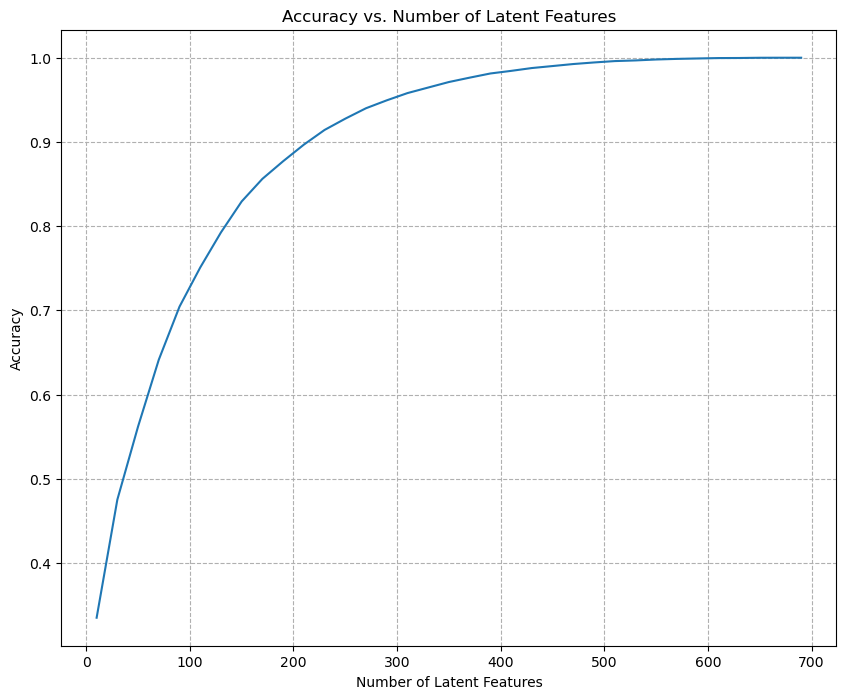

In [153]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.figure(figsize=(10,8))
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features')
plt.grid(linestyle='--');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  



In [155]:
#First, we split our data

df_train = df.head(40000)
df_test = df.tail(5993)

In [156]:
df_test.tail()

,article_id,title,user_id,ranking_count
45988,1324.0,ibm watson facebook posts for 2015,5146,9
45989,142.0,neural networks for beginners: popular types a...,5146,9
45990,233.0,bayesian nonparametric models – stats and bots,5147,1
45991,1160.0,analyze accident reports on amazon emr spark,5148,1
45992,16.0,higher-order logistic regression for large dat...,5149,1


In [157]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''    
    # create user_item matrix into test and train
    user_item_train = create_user_item_matrix(df_train)   
    user_item_test = create_user_item_matrix(df_test)
    
    # all test user ids
    test_idx = user_item_test.index.values
        
    # get all unique test article ids
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [158]:
user_item_train.shape

(4487, 714)

In [159]:
user_item_test.shape

(682, 574)

In [160]:
test_idx.shape

(682,)

In [161]:
test_arts.shape

(574,)

Using the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

##### Here, we take advantage of numpy's methods `intersect1d` and `setdiff1d`. Simply, `np.intersect1d` sorts and outputs common elements between arrays, while `np.setdiff1d` ouputs elements in the first array that are not in the second.

The basis for this is because we can predict only what is in BOTH the train and test dataframes, anything unique to each, cant be predicted

In [165]:
print('How many USERS CAN we predict for:')
len(np.intersect1d(df_test['user_id'].unique(), df_train['user_id'].unique()))

How many USERS CAN we predict for:


20

In [166]:
print('How many USERS CANT we predict for:')
len(np.setdiff1d(df_test['user_id'].unique(), df_train['user_id'].unique()))

How many USERS CANT we predict for:


662

In [167]:
print('How many ARTICLES CAN we predict:')
len(np.intersect1d(df_test['article_id'].unique(), df_train['article_id'].unique()))

How many ARTICLES CAN we predict:


574

In [168]:
print('How many ARTICLES CANT we predict:')
len(np.setdiff1d(df_test['article_id'].unique(), df_train['article_id'].unique()))

How many ARTICLES CANT we predict:


0

In [169]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now we use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [171]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)       #Setting full_matrices=False in SVD computes reduced matrices for efficiency, using less memory and computation while retaining essential information for matrix reconstruction.

In [172]:
u_test = u_train[user_item_train.index.isin(test_idx),:]
vt_test = vt_train[:,user_item_train.columns.isin(test_arts)]
user_item_test_new = user_item_test[user_item_test.index.isin(set(user_item_train.index).intersection(user_item_test.index))]

/Users/chrismo/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


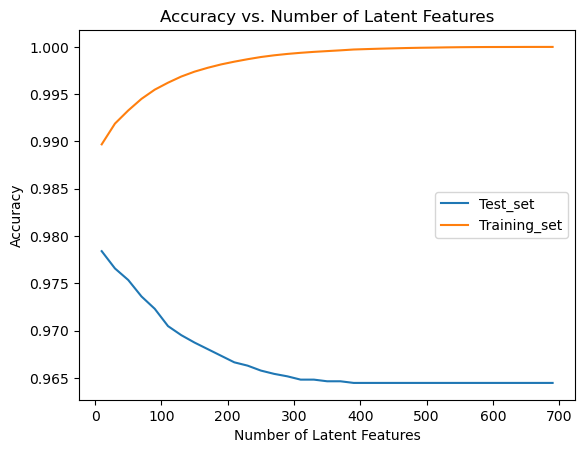

In [173]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:,:k], vt_test[:k,:]
    
    # take dot product for our training predictions
    user_item_train_pred = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # take dot product for our testing predictions
    user_item_test_pred = np.around(np.dot(np.dot(u_test_new, s_new), vt_test_new))
    
    # computing error in each latent feature training
    diffs_train = np.subtract(user_item_train, user_item_train_pred)
    
    # computing error in each latent feature testing
    diffs_test = np.subtract(user_item_test_new, user_item_test_pred)

    # total errors
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    test_err = np.sum(np.sum(np.abs(diffs_test)))


    sum_errs_train.append(train_err)
    sum_errs_test.append(test_err)

    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test_new.shape[0] * user_item_test.shape[1]), label = 'Test_set');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0] * user_item_test.shape[1]), label = 'Training_set');
plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

#### Plot Insights:


##### * Training Set (Orange Line): As the number of latent features increases, the training accuracy rapidly approaches 1.0, indicating that the model is fitting the training data very well.

##### * Test Set (Blue Line): The test accuracy decreases as the number of latent features increases. This suggests overfitting, where the model performs well on the training data but poorly on unseen data.

# <a class="anchor" id="conclusions">Part VI : Extras & Concluding</a>


##### We use the cell below to comment on the results we found in the previous questions. Given the circumstances of our results, we discuss what we might do to determine if the recommendations we make with any of the above recommendation systems are an improvement to how users currently find articles? 


### For comparisms, A/B testing is a top method for evaluating this recommendation system. By splitting data into control and test groups and monitoring metrics such as CTR, articles read, user engagement, and bounce rate, we can quantify how effective our engine is 

In [179]:
!jupyter nbconvert --to html Recommendations_with_IBM.ipynb

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 840701 bytes to Recommendations_with_IBM.html
